Прогнозирование согласия клиентов на оформление срочного депозита с помощью Decision Trees моделей (RandomForestClassifier). Метрика F1: 54%. Классы не сбалансированны 1:8
Визуализации сохранены в папке `images/`
- Источник: `bank.csv`  

Запустите все ячейки по порядку.  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,roc_curve,confusion_matrix,precision_recall_curve,average_precision_score,auc

In [2]:
data = pd.read_csv("bank.csv", sep=';')
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [3]:

X = data.drop(columns=["y"])
y = data['y']
X_encoded = pd.get_dummies(X)
y_encoded = data["y"].map({"no": 0, "yes": 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)


In [4]:
print(f"Распределение классов:\n{y_encoded.value_counts(normalize=True)*100}")


Распределение классов:
y
0    88.476001
1    11.523999
Name: proportion, dtype: float64


У нас соотношение классов 1 к 8. Поэтому поищем балансировку

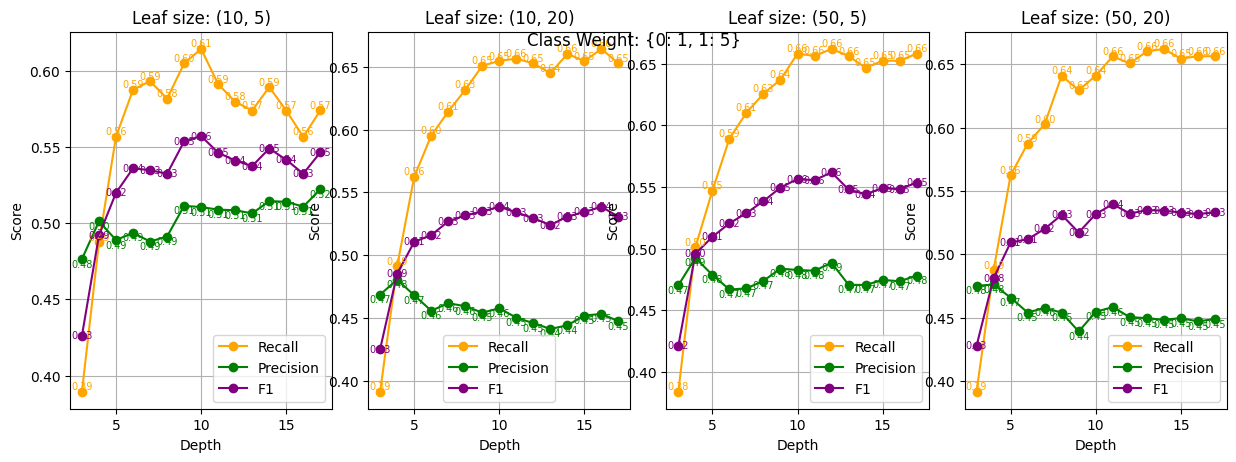

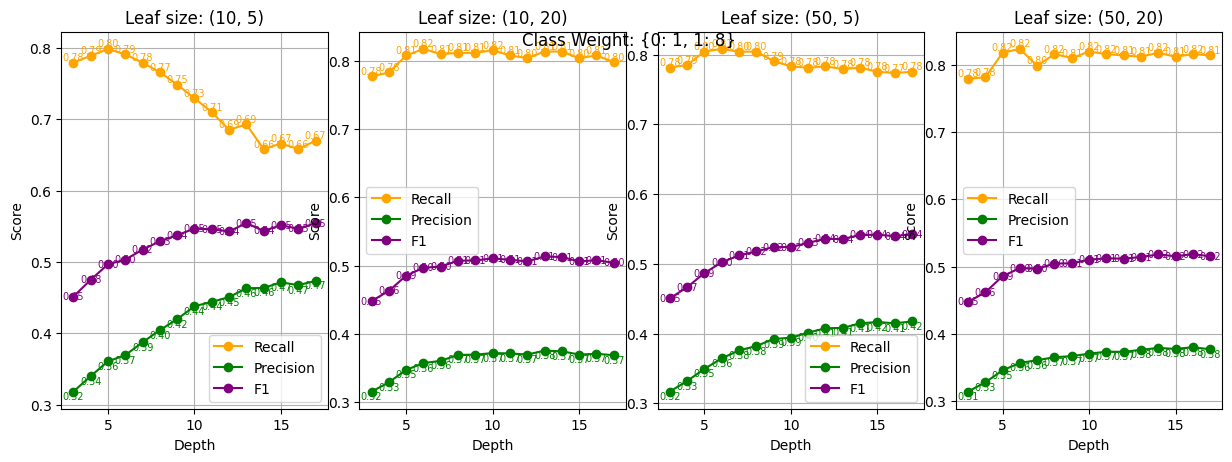

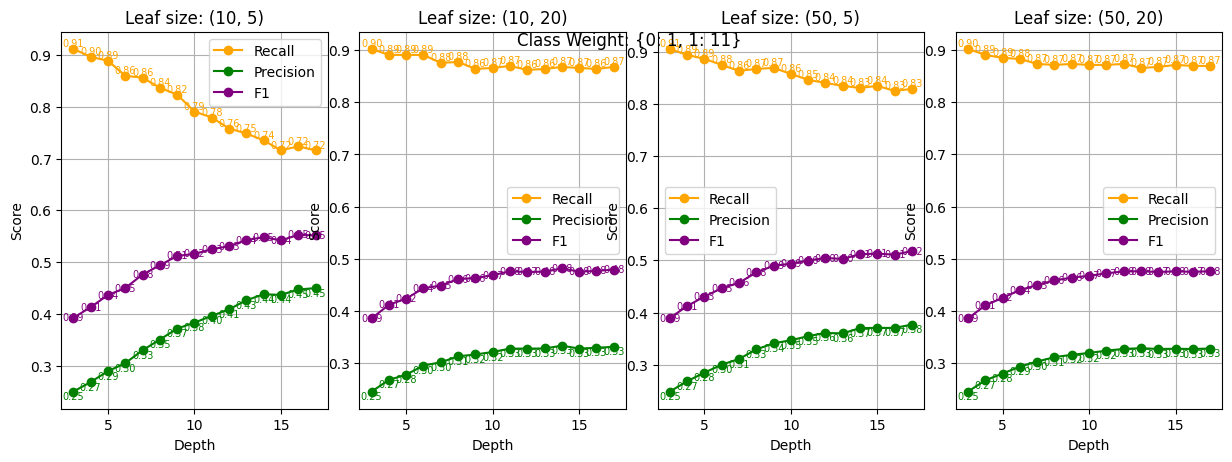

In [ ]:
depths = range(3, 18)
min_samples_splits = [10, 50]
min_samples_leaf = [5, 20]
criteria = ["gini"] #, "entropy"
resoult = []
n_estimators = 100
class_weights_list = [{0: 1, 1: 5},{0: 1, 1: 8},{0: 1, 1: 11}] #Тестируем при каком балансе результаты будут лучше

for class_weights in class_weights_list:
    for depth in depths:
        for f in min_samples_splits:
            for w in min_samples_leaf:

                    for ccc in criteria:
                        model = RandomForestClassifier(            n_estimators=n_estimators,
                            max_depth=depth,min_samples_split=f,min_samples_leaf=w, criterion=ccc, random_state=42,class_weight=class_weights,n_jobs=-1
                        )
                        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

                        scoring_metrics = {
                            "accuracy": "accuracy",
                            "recall": "recall",
                            "precision": "precision",
                            "f1": "f1"
                        }

                        scores = cross_validate(
                            model, X_encoded, y_encoded, cv=cv, scoring=scoring_metrics, return_estimator=True
                        )

                        resoult.append({
                            "class_weight": str(class_weights),
                            "depth": depth,
                            "min_samples_split": f,
                            "min_samples_leaf":w,
                            "criterion": ccc,
                            "accuracy": scores["test_accuracy"].mean(),
                            "recall": scores["test_recall"].mean(),
                            "precision": scores["test_precision"].mean(),
                            "f1": scores["test_f1"].mean()
                        })
results_df = pd.DataFrame(resoult)


for criterion in criteria:
    for class_weight in class_weights_list:
        weight_str = str(class_weight)

        weight_subset = results_df[
            (results_df["criterion"] == criterion) & 
            (results_df["class_weight"] == weight_str)
        ]
        unique_groups = weight_subset.groupby(["min_samples_split","min_samples_leaf"]).groups
        plt.figure(figsize=(25, 35))
        for i, (group, indices) in enumerate(unique_groups.items()):
            subset = weight_subset.loc[indices]
            plt.subplot(3, 4, i + 1)
            plt.plot(subset["depth"], subset["recall"], label="Recall", marker='o', color='orange')
            plt.plot(subset["depth"], subset["precision"], label="Precision", marker='o', color='green')
            plt.plot(subset["depth"], subset["f1"], label="F1", marker='o', color='purple')

            for x, y_rec, y_prec,y_f1 in zip(subset["depth"], subset["recall"], subset["precision"],subset["f1"]):
                plt.text(x, y_rec, f"{y_rec:.2f}", ha='center', va='bottom', fontsize=7, color='orange')
                plt.text(x, y_prec, f"{y_prec:.2f}", ha='center', va='top', fontsize=7, color='green')
                plt.text(x, y_f1, f"{y_f1:.2f}", ha='center', va='center', fontsize=7, color='purple')
            plt.title(f"Leaf size: {group}")
            plt.xlabel("Depth")
            plt.ylabel("Score")
            plt.legend()
            plt.grid(True)
        
        plt.suptitle(f"Class Weight: {weight_str}", y=0.98)
        plt.tight_layout()

        #weight_str_clean = weight_str.replace("{", "").replace("}", "").replace(":", "").replace(",", "_").replace(" ", "")
        #plt.gcf().set_size_inches(12, 12)  # Устанавливаем размер только для текущего графика перед сохранением
        #plt.savefig(f'images/graf_{criterion}_{weight_str_clean}.png', dpi=150, bbox_inches='tight', pad_inches=0.3)

        plt.show()

![График 11](./images/graf_gini_01_15.png)
![График 12](./images/graf_gini_01_18.png)
![График 13](./images/graf_gini_01_111.png)

Видим что min_samples_leaf 20 хуже чем 5,а min_samples_split 50 в среднем равно 10
Самые плохие метрики на вид у class_weight 0: 1, 1: 11 - её больше использовать не будем.
Видим что маленькая глубина не имеет смысла,а большую надо проверить потому, что метрики у 1: 8 в целом растут на большой глубине

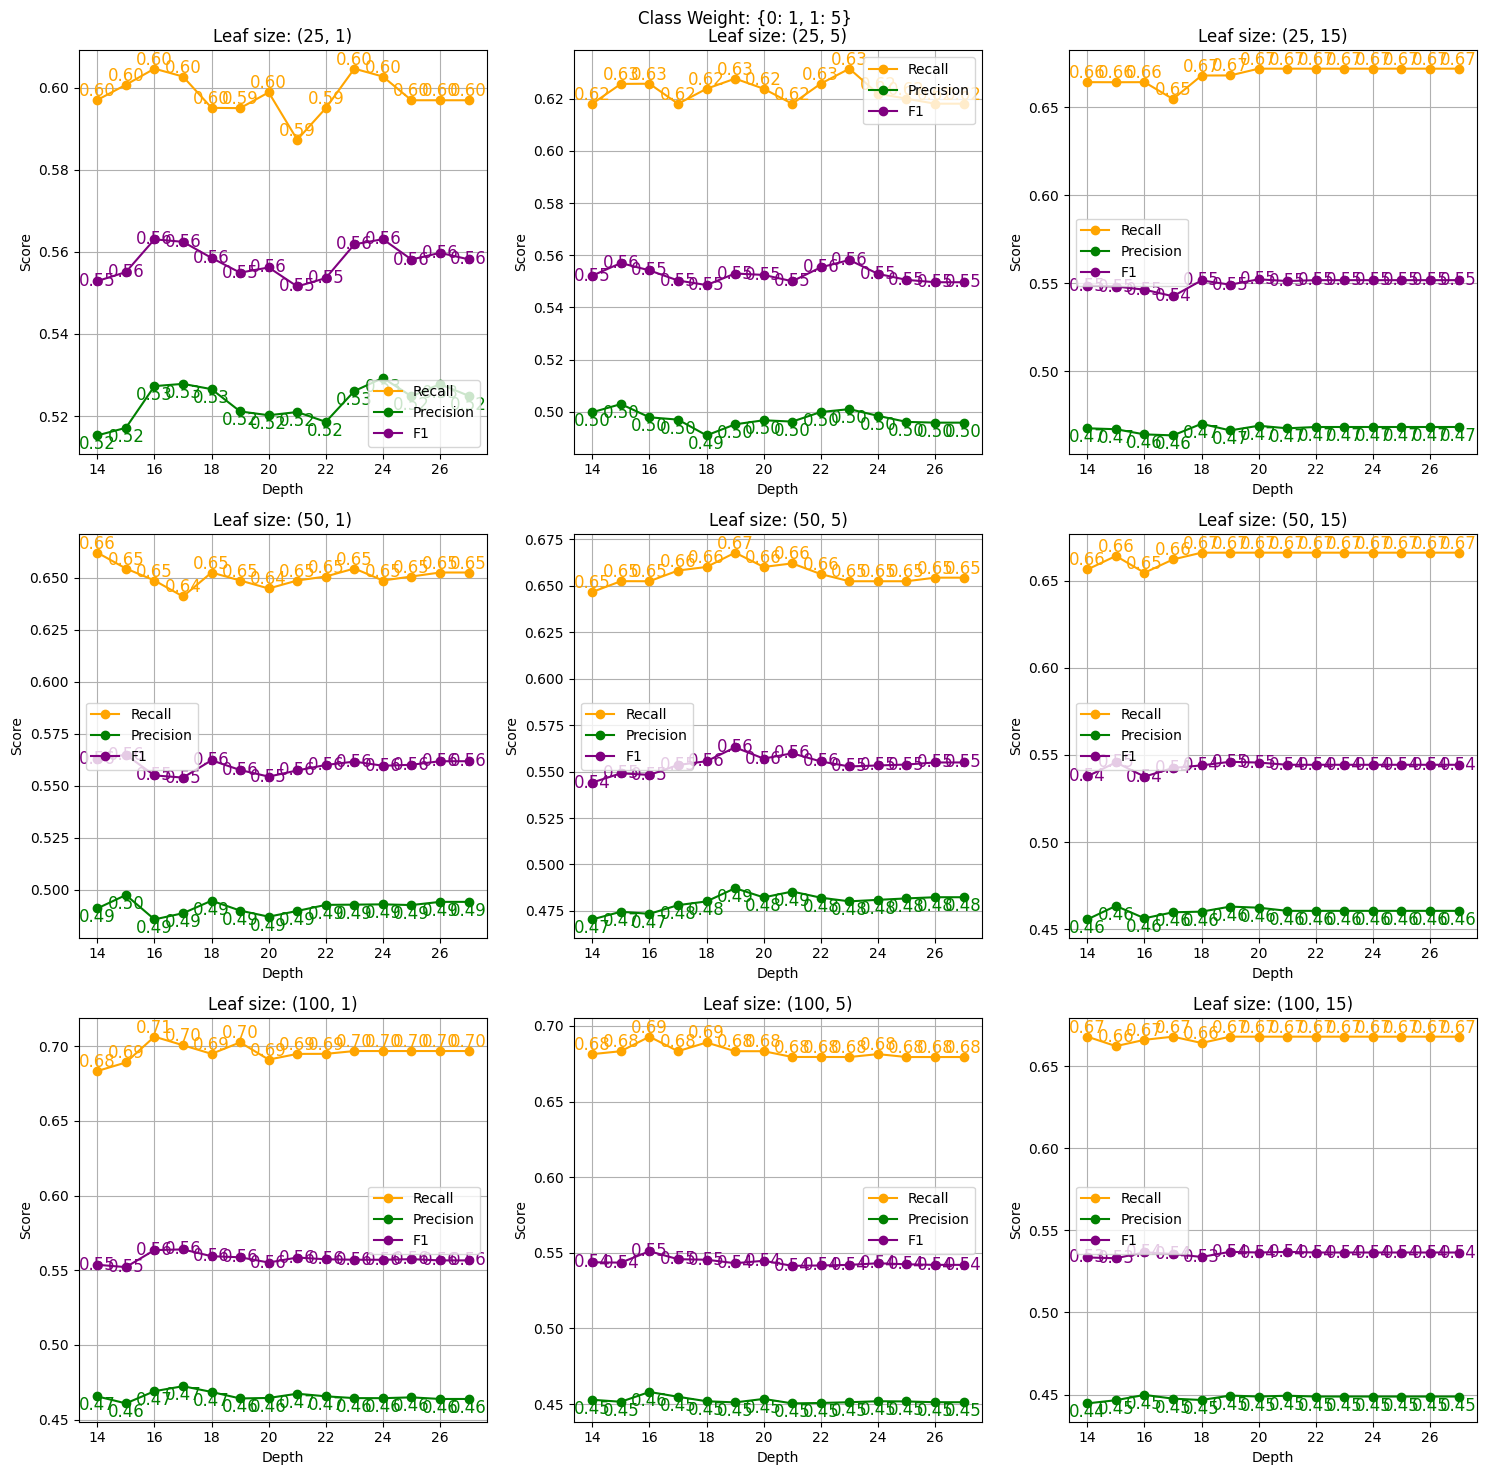

In [ ]:
depths = range(14, 28)
min_samples_splits = [25, 50,100]
min_samples_leaf = [1,5,15]
criteria = ["gini"] #, "entropy"
resoult = []
n_estimators = 100
class_weights_list = [{0: 1, 1: 5}]

for class_weights in class_weights_list: 
    for depth in depths:
        for f in min_samples_splits:
            for w in min_samples_leaf:

                    for ccc in criteria:
                        model2 = RandomForestClassifier(            n_estimators=n_estimators,
                            max_depth=depth,min_samples_split=f,min_samples_leaf=w, criterion=ccc, random_state=42,class_weight=class_weights,n_jobs=-1
                        )
                        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

                        scoring_metrics = {
                            "recall": "recall",
                            "precision": "precision",
                            "f1": "f1"
                        }

                        scores = cross_validate(
                            model2, X_encoded, y_encoded, cv=cv, scoring=scoring_metrics, return_estimator=True
                        )

                        resoult.append({
                            "class_weight": str(class_weights),
                            "depth": depth,
                            "min_samples_split": f,
                            "min_samples_leaf":w,
                            "criterion": ccc,
                            "recall": scores["test_recall"].mean(),
                            "precision": scores["test_precision"].mean(),
                            "f1": scores["test_f1"].mean()
                        })

results_df = pd.DataFrame(resoult)

for criterion in criteria:
    for class_weight in class_weights_list:
        weight_str = str(class_weight)
        plt.figure(figsize=(15, 15))
        
        weight_subset = results_df[
            (results_df["criterion"] == criterion) & 
            (results_df["class_weight"] == weight_str)
        ]
        unique_groups = weight_subset.groupby(["min_samples_split","min_samples_leaf"]).groups
        
        for i, (group, indices) in enumerate(unique_groups.items()):
            subset = weight_subset.loc[indices]
            plt.subplot(3, 3, i + 1)
            plt.plot(subset["depth"], subset["recall"], label="Recall", marker='o', color='orange')
            plt.plot(subset["depth"], subset["precision"], label="Precision", marker='o', color='green')
            plt.plot(subset["depth"], subset["f1"], label="F1", marker='o', color='purple')
            for x, y_rec, y_prec,y_f1 in zip(subset["depth"], subset["recall"], subset["precision"],subset["f1"]):
                plt.text(x, y_rec, f"{y_rec:.2f}", ha='center', va='bottom', fontsize=12, color='orange')
                plt.text(x, y_prec, f"{y_prec:.2f}", ha='center', va='top', fontsize=12, color='green')
                plt.text(x, y_f1, f"{y_f1:.2f}", ha='center', va='center', fontsize=12, color='purple')
            plt.title(f"Leaf size: {group}")
            plt.xlabel("Depth")
            plt.ylabel("Score")
            plt.legend()
            plt.grid(True)
        plt.suptitle(f"Class Weight: {weight_str}", y=0.98)
        plt.tight_layout()
        #plt.savefig('images/graf2.png', dpi=150)
        plt.show()

![График 2](./images/graf2.png)

Примерно видно, что увеличение min_samples_leaf ухудшает f1 метрику,а так же min_samples_split 100 и 25 чуть хуже чем 50.
строим рандомайзер примерно вокруг этого

In [64]:
#Для приблизительного выяснения правильных метрик
FF=RandomForestClassifier()
param_dist = {
    "min_samples_split": randint(10, 100),  
    "min_samples_leaf": randint(1, 10),    # 
    "max_depth": randint(15, 27),           # совсем малые значения на графиках не эффективны
    "class_weight": [{0: 1, 1: 5}, {0: 1, 1: 8}, {0: 1, 1: 3}],  # Избранные пропорции для class_weight
    "n_estimators": randint(100, 300)  
}

random_search = RandomizedSearchCV(FF, param_distributions=param_dist, n_iter=60, scoring="f1", cv=10, n_jobs=-1,random_state=42)
random_search.fit(X_encoded, y_encoded)

print("Лучшие параметры:", random_search.best_params_)
print("Лучшая f1:", random_search.best_score_)

Лучшие параметры: {'class_weight': {0: 1, 1: 5}, 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 75, 'n_estimators': 153}
Лучшая f1: 0.5607764516709741


На RandomizedSearchCV у меня получилось  
1-й раз  
Лучшие параметры: {'class_weight': {0: 1, 1: 8}, 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 21, 'n_estimators': 138}
Лучшая f1: 0.5612084187450002  
2-й раз  
Лучшие параметры: {'class_weight': {0: 1, 1: 5}, 'max_depth': 17, 'min_samples_leaf': 5, 'min_samples_split': 56, 'n_estimators': 230}
Лучшая f1: 0.5610503045945263  
3-й раз  
Лучшие параметры: {'class_weight': {0: 1, 1: 5}, 'max_depth': 15, 'min_samples_leaf': 8, 'min_samples_split': 48, 'n_estimators': 181}
Лучшая f1: 0.5594600111309368   
4-й раз  
Лучшие параметры: {'class_weight': {0: 1, 1: 8}, 'max_depth': 22, 'min_samples_leaf': 4, 'min_samples_split': 11, 'n_estimators': 233}
Лучшая f1: 0.5655169918344781   
Лучшие параметры: {'class_weight': {0: 1, 1: 5}, 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 75, 'n_estimators': 153}
Лучшая f1: 0.5607764516709741  

Руководствуясь теми наблюдениями на графиках,что у нас были и полученными из рандомайзера
слишком малые значения min_samples_split неэффективны.Хороший диапазон крутиться примерно вокруг 50


In [65]:
#Перебираем около параметры.( УТОЧНЯЮЩИЙ ПЕРЕБОР )
param_grid = {
    "min_samples_split" : [11,21,48,56,75],
    "min_samples_leaf": [1,2,8,4,5],  
    "max_depth": [15, 17, 16, 22, ],
    "class_weight": [{0: 1, 1: 5}, {0: 1, 1: 6}, {0: 1, 1: 4}, {0: 1, 1: 8}],
    "n_estimators":[150,200,250]
}

grid_search = GridSearchCV(FF, param_grid, scoring="f1", cv=10, n_jobs=-1)
grid_search.fit(X_encoded, y_encoded)

print("Лучшее min_samples_leaf:", grid_search.best_params_["min_samples_leaf"])
print("Лучшее min_samples_split:", grid_search.best_params_["min_samples_split"])
print("Лучшая глубина дерева:", grid_search.best_params_["max_depth"])
print("Лучший f1-score:", grid_search.best_score_)
print("Лучшая class_weight:", grid_search.best_params_["class_weight"])
print("Лучшая n_estimators:", grid_search.best_params_["n_estimators"])

Лучшее min_samples_leaf: 1
Лучшее min_samples_split: 48
Лучшая глубина дерева: 22
Лучший f1-score: 0.5711131162760579
Лучшая class_weight: {0: 1, 1: 6}
Лучшая n_estimators: 150


Полученные параметры лучшей модели  
Лучшее min_samples_leaf: 1
Лучшее min_samples_split: 48
Лучшая глубина дерева: 22
Лучший f1-score: 0.5711131162760579
Лучшая class_weight: {0: 1, 1: 6}
Лучшая n_estimators: 150

In [20]:
#Проверяем модель на обучающих и тестовых данных,а не на кросс валидации
DD = RandomForestClassifier(n_estimators=150,max_depth=22,min_samples_split=48,min_samples_leaf=1, criterion='gini', random_state=42,class_weight={0: 1, 1: 6},n_jobs=-1)
DD.fit(X_train1, y_train1) 
# обучаем модель на train и предсказываем test. До этого делали на X_encoded y_encoded

y_pred1 = DD.predict(X_test1)

y_pred_proba1 = DD.predict_proba(X_test1)[:, 1]
f1 = f1_score(y_test1, y_pred1)
print(f"F1-score: {f1:.8}")
#метрика F1-score: 0.55060729 на полученных параметрах видим что она не сильно хуже 0.5711131 полученной ранее на X_encoded y_encoded


F1-score: 0.55060729


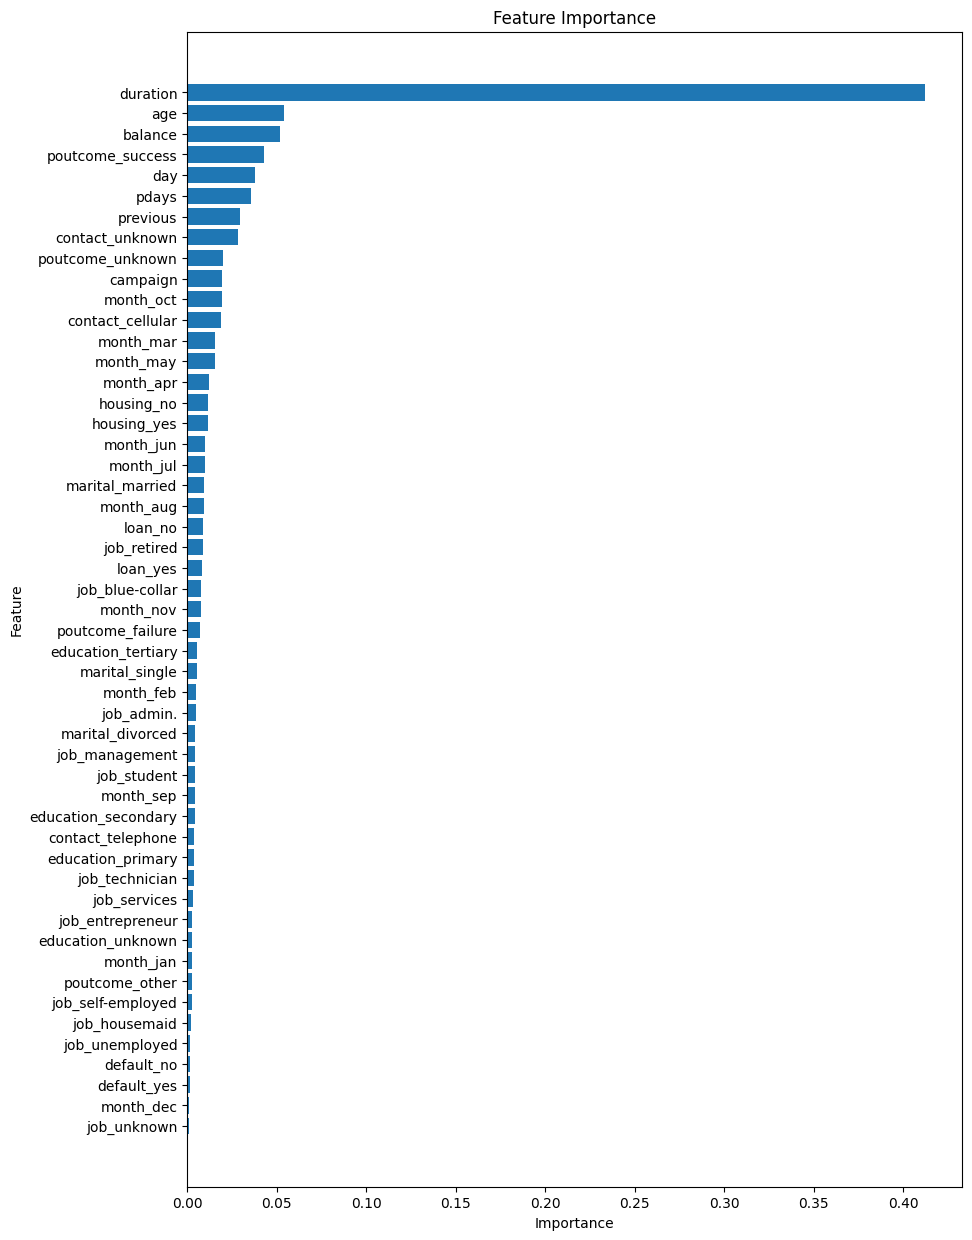

,Feature,Importance
3,duration,0.412503
0,age,0.054314
1,balance,0.051909
49,poutcome_success,0.043094
2,day,0.037664
5,pdays,0.035695
6,previous,0.029463
34,contact_unknown,0.028191
50,poutcome_unknown,0.019831
4,campaign,0.019579


In [ ]:
DD.fit(X_encoded, y_encoded)
importances = DD.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 15))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
#plt.savefig('images/barn1.png', dpi=150)
plt.show()

feature_importance_df.head(40)

![важность](./images/barn1.png)

In [24]:
#Немного упростим удалив неиспользуемые признаки
features = feature_importance_df[feature_importance_df['Importance'] < 0.02]['Feature']
low_importance_features = features.tolist()
print(f"Было признаков: {X_encoded.shape[1]}")
X_encoded = X_encoded.drop(columns=low_importance_features) #Удаляем отсееные признаки 
print(f"Стало признаков: {X_encoded.shape[1]}")
print(f"Удалено признаков: {len(low_importance_features)}")


Было признаков: 51
Стало признаков: 8
Удалено признаков: 43


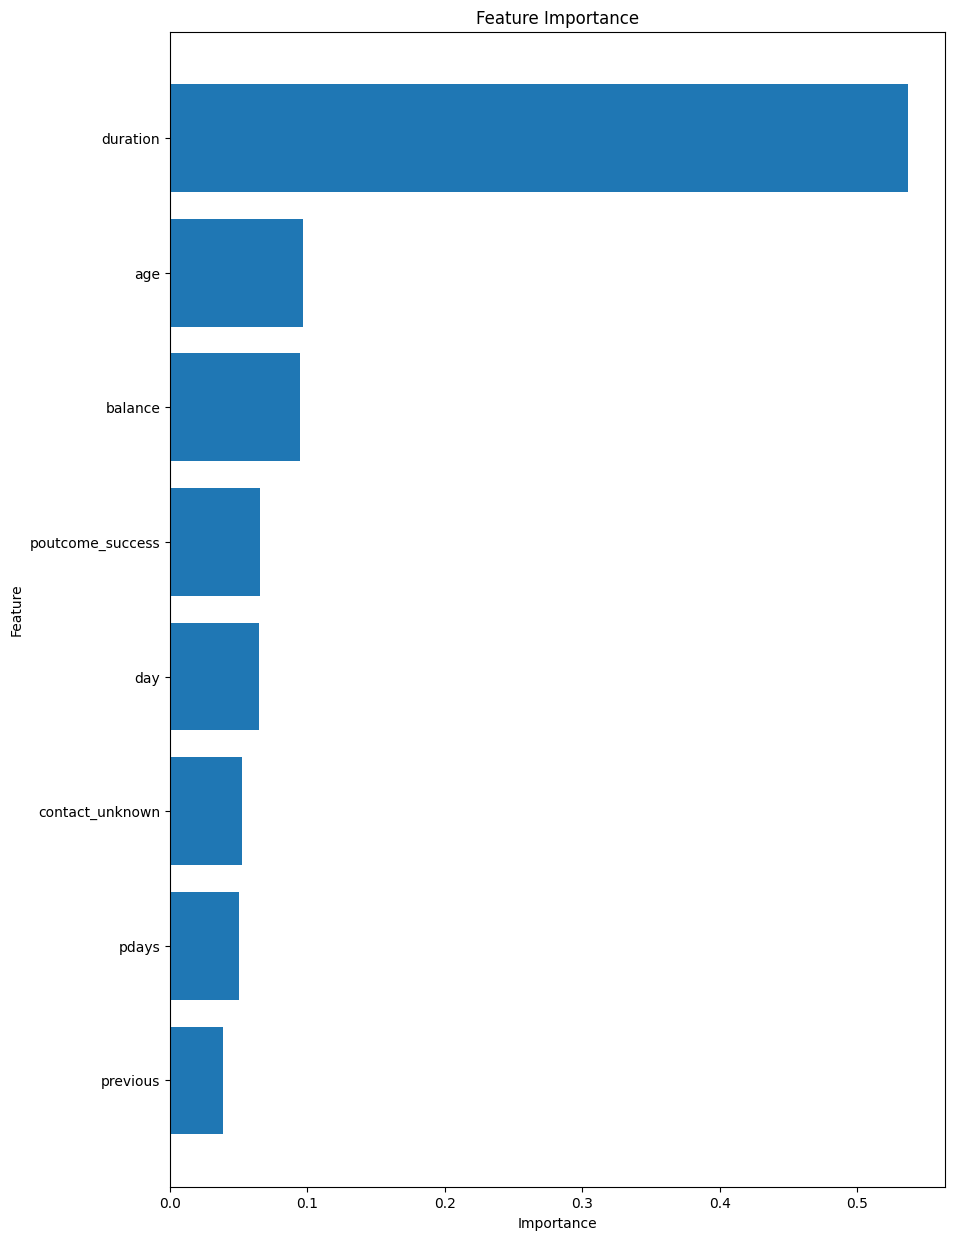

,Feature,Importance
3,duration,0.536761
0,age,0.096645
1,balance,0.094688
7,poutcome_success,0.065247
2,day,0.064971
6,contact_unknown,0.052711
4,pdays,0.050391
5,previous,0.038586


In [ ]:
DD.fit(X_encoded, y_encoded)
importances = DD.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 15))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
#plt.savefig('images/barn2.png', dpi=150)
plt.show()

feature_importance_df.head(40)

![важность2](./images/barn2.png)

In [27]:
#Здесь мы снова делим чтобы получить X_train\text без удалённых признаков
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42) 

In [28]:
DD = RandomForestClassifier(n_estimators=150,max_depth=22,min_samples_split=48,min_samples_leaf=1, criterion='gini', random_state=42,class_weight={0: 1, 1: 6},n_jobs=-1)
DD.fit(X_train2, y_train2) #эти данные уже не те на которых выявлялись параметры для модели
#далее обучаем модель на других данных не на которых обучали. ну точнее на train test от тех данных
#DD.fit(X_encoded, y_encoded)
y_pred2 = DD.predict(X_test2)

# Предсказываем вероятности для тестового набора
y_pred_proba2 = DD.predict_proba(X_test2)[:, 1]

f1 = f1_score(y_test2, y_pred2)
print(f"F1-score: {f1:.8}")
#метрика F1-score: 0.54135338 видим что метрика не изменилась - значит удалённые признаки не влияют на качество модели

F1-score: 0.54135338


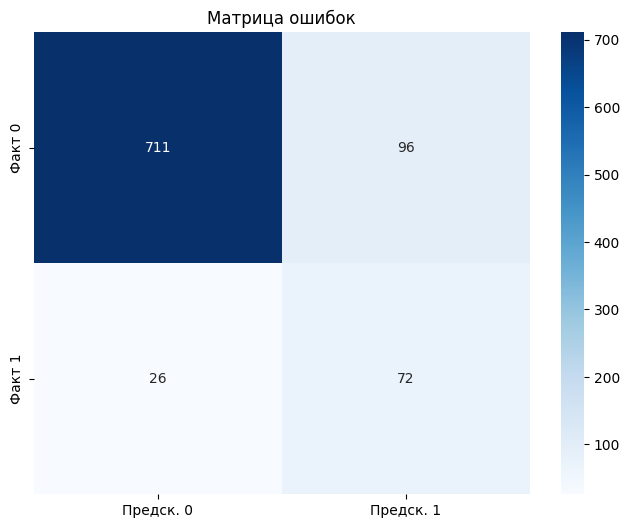

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test2, y_pred2), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Предск. 0', 'Предск. 1'],
            yticklabels=['Факт 0', 'Факт 1'])
plt.title('Матрица ошибок')
#plt.savefig('images/matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [30]:

dummy = DummyClassifier(strategy="uniform")  # случайное угадывание
dummy.fit(X_train2, y_train2)
y_dummy_proba = dummy.predict_proba(X_test2)[:, 1]  # вероятность для класса 1
dummy_fpr, dummy_tpr, _ = roc_curve(y_test2, y_dummy_proba)
dummy_auc = roc_auc_score(y_test2, y_dummy_proba)

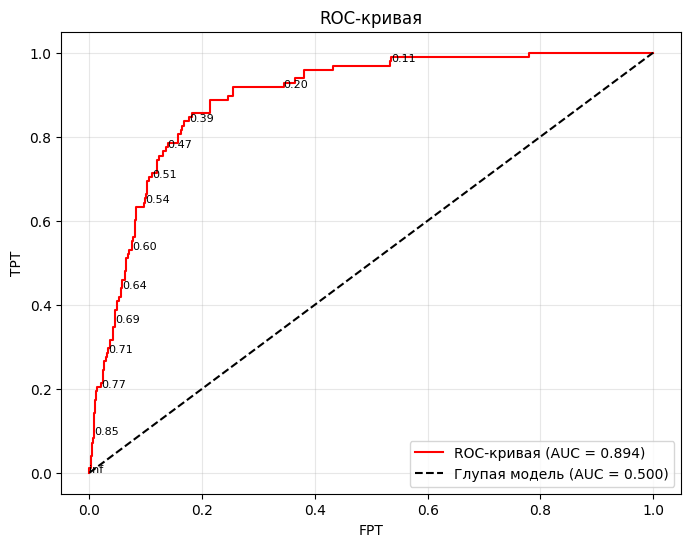

ROC-AUC: 0.894


In [ ]:
fpr, tpr, _ = roc_curve(y_test2, y_pred_proba2)
roc_auc = roc_auc_score(y_test2, y_pred_proba2)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC-кривая (AUC = {roc_auc:.3f})')
plt.plot(dummy_fpr, dummy_tpr, 'k--', label=f'Глупая модель (AUC = {dummy_auc:.3f})')
for i in range(0, len(_), 10):  # Каждый 10-й порог
    plt.text(fpr[i], tpr[i], f"{_[i]:.2f}", fontsize=8)

plt.xlabel('FPT')
plt.ylabel('TPT')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
#plt.savefig('images/grafROC.png', dpi=150, bbox_inches='tight')
plt.show()
#Здесь наглядно видно, на сколько наша модель лучше случайного значения))
print(f"ROC-AUC: {roc_auc:.3f}")

![ROC](./images/grafROC.png)

PR-AUC: 0.47
PR-AUC на случайной модели: 0.108


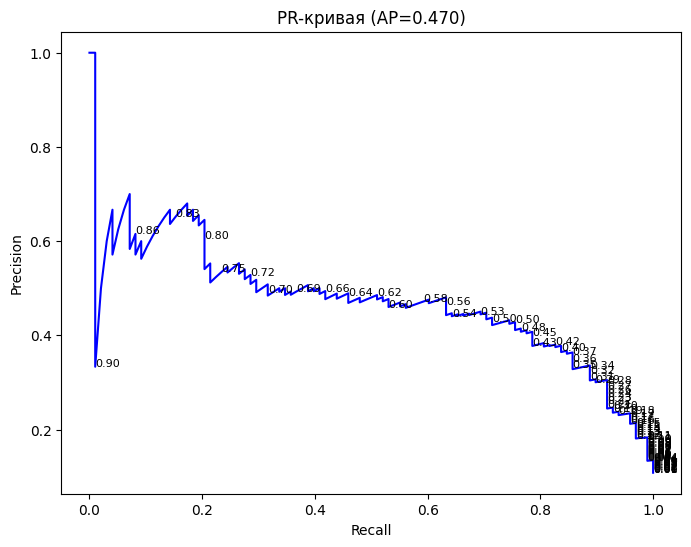

In [ ]:
precision, recall, _ = precision_recall_curve(y_test2, y_pred_proba2)
plt.figure(figsize=(8, 6)) 
plt.plot(recall, precision, color='blue')
pr_auc = auc(recall, precision)
plt.title(f'PR-кривая (AP={pr_auc:.3f})')

for i in range(0, len(_), 10):  # Каждый 10-й порог
    plt.text(recall[i], precision[i], f"{_[i]:.2f}", fontsize=8)

plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.savefig('images/grafPR.png', dpi=150, bbox_inches='tight')

print(f"PR-AUC: {pr_auc:.3}")
pr_auc_dummy = average_precision_score(y_test2, y_dummy_proba)
print(f"PR-AUC на случайной модели: {pr_auc_dummy:.3f}")
#Видим что случайная модель даёт 0.108, что значительно меньше. Значит не всё так плохо

![PR](./images/grafPR.png)

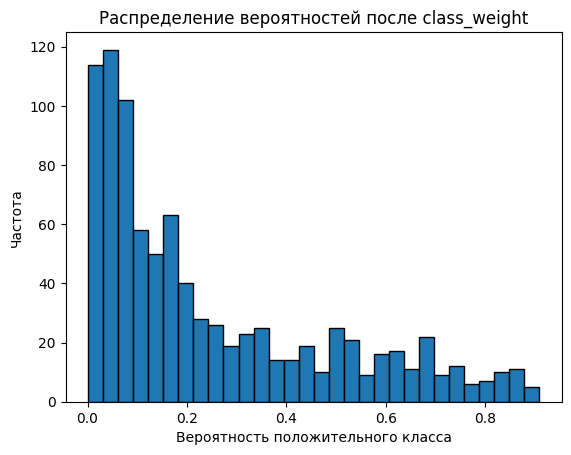

In [ ]:
#Здесь мы видим распределение каких сколько вероятностей,чтобы увидеть какой порог повлияет на большее количество
y_scores = DD.predict_proba(X_test2)[:, 1]  # Вероятности для положительного класса

plt.hist(y_scores, bins=30, edgecolor='black')
plt.xlabel("Вероятность положительного класса")
plt.ylabel("Частота")
plt.title("Распределение вероятностей после class_weight")
#plt.savefig('images/hist.png', dpi=150, bbox_inches='tight')
plt.show()


![hist](./images/hist.png)

In [37]:
for i in range(3,7):
    e=i/10
    optimal_threshold = e
    print(e)
    y_pred_custom = (y_scores >= optimal_threshold).astype(int)
    f1 = f1_score(y_test2, y_pred_custom)
    precision = precision_score(y_test2, y_pred_custom, pos_label=1)
    recall = recall_score(y_test2, y_pred_custom, pos_label=1)

    print(f"Precision: {precision}")
    print(f"Recall : {recall}")
    print("F1-score:", f1)



0.3
Precision: 0.3041958041958042
Recall : 0.8877551020408163
F1-score: 0.453125
0.4
Precision: 0.36936936936936937
Recall : 0.8367346938775511
F1-score: 0.5125
0.5
Precision: 0.42857142857142855
Recall : 0.7346938775510204
F1-score: 0.5413533834586466
0.6
Precision: 0.46956521739130436
Recall : 0.5510204081632653
F1-score: 0.5070422535211268


In [ ]:
#Мы видим что только 4 и 5 пороги дают более менее хорошие результаты. Здесь надо выбрать в зависимости от задачи. Естественный порог 0.5 мне видится оптимальным,но
#возможно, что и 0.4 может оказаться валиднее если задача найти как можно больше возможных подписчиков.. (В случае дешевой рекламной рассылки).
#Я не буду менять порог - оставлю 0.5

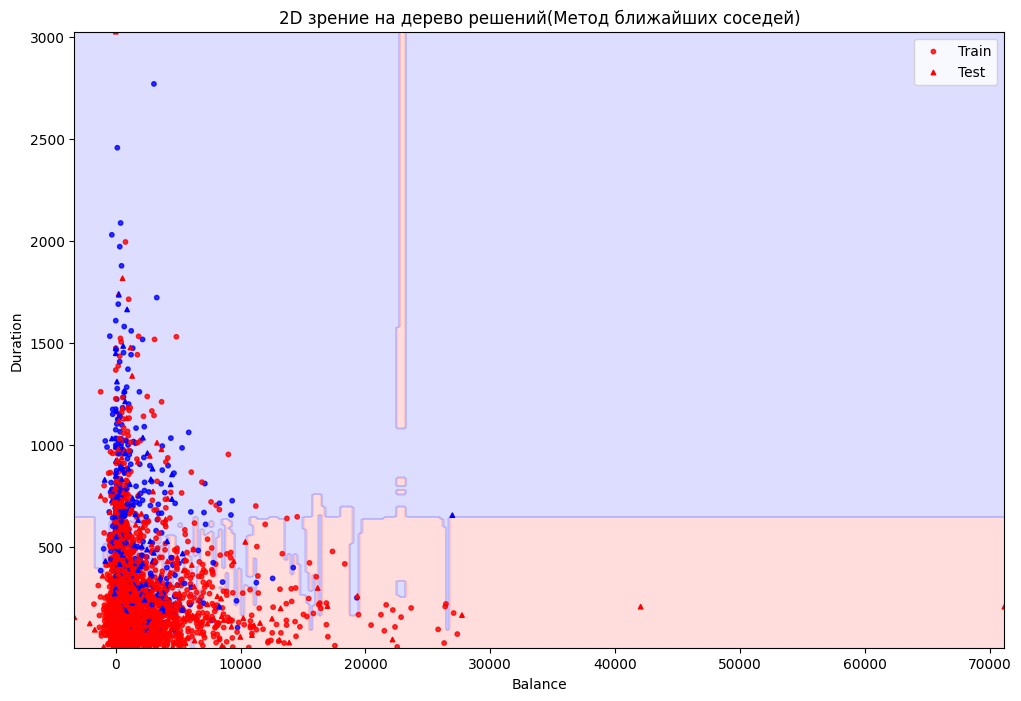

In [ ]:

n_estimators=100

#Далее здесь вариант 2д отображения областей дерева, сетка которого заполняется по методу ближайших соседей
X_all = pd.concat([X_train2, X_test2])
x_min, x_max = X_all['balance'].min(), X_all['balance'].max()
y_min, y_max = X_all['duration'].min(), X_all['duration'].max()

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

grid_df = pd.DataFrame(grid, columns=['balance', 'duration'])

# Поиск ближайших соседей 
nb = NearestNeighbors(n_neighbors=1).fit(X_train2[['balance', 'duration']])
distances, indices = nb.kneighbors(grid_df[['balance', 'duration']])

for col in X_train2.columns:
    if col not in ['balance', 'duration']:
        grid_df[col] = X_train2.iloc[indices.flatten()][col].values

grid_df = grid_df[X_train2.columns]

Z = DD.predict(grid_df)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))

plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))

plt.scatter(X_train2['balance'], X_train2['duration'], 
            c=y_train2, cmap=ListedColormap(['red', 'blue']),
            s=10, alpha=0.8, label='Train')

plt.scatter(X_test2['balance'], X_test2['duration'], 
            c=y_test2, cmap=ListedColormap(['red', 'blue']),
            s=10, alpha=1,marker='^', label='Test')

plt.xlabel("Balance")
plt.ylabel("Duration")
plt.title("2D зрение на дерево решений(Метод ближайших соседей)")
plt.legend()
#plt.savefig('images/graf2d1.png', dpi=150)
plt.show()

графики выглядят не удачно, возможно потому что мы пытаемся отобразить многомерную модель в 2D


![graf2d1](./images/graf2d1.png)

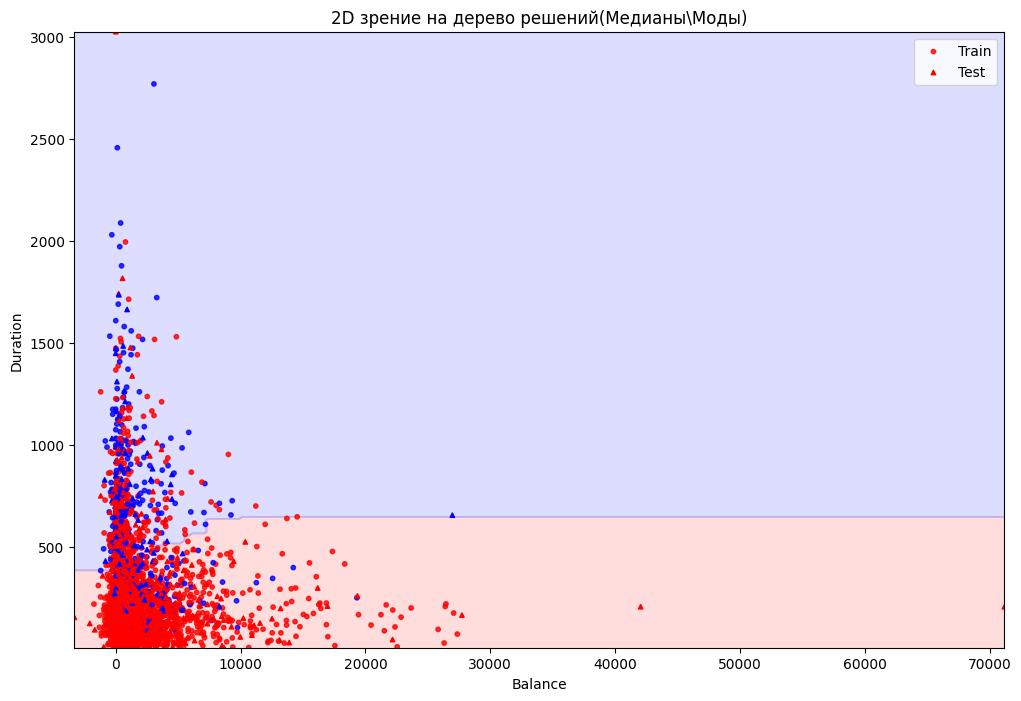

In [ ]:

X_all = pd.concat([X_train2, X_test2])
x_min, x_max = X_all['balance'].min(), X_all['balance'].max()
y_min, y_max = X_all['duration'].min(), X_all['duration'].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid_data = []

fixed_values = {}
for col in X_train2.columns:
    if col not in ['balance', 'duration']:
        if X_train2[col].dtype in ['int64', 'float64']:
            fixed_values[col] = X_train2[col].median()
        else:
            fixed_values[col] = X_train2[col].mode()[0]


for x, y in zip(xx.ravel(), yy.ravel()):
    row = fixed_values.copy()  
    row['balance'] = x         
    row['duration'] = y
    grid_data.append(row)
    
grid_df = pd.DataFrame(grid_data)[X_train2.columns] 

Z = DD.predict(grid_df)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
plt.scatter(X_train2['balance'], X_train2['duration'], 
            c=y_train2, cmap=ListedColormap(['red', 'blue']),
            s=10, alpha=0.8, label='Train')
plt.scatter(X_test2['balance'], X_test2['duration'], 
            c=y_test2, cmap=ListedColormap(['red', 'blue']),
            s=10, alpha=1, marker='^', label='Test')
plt.xlabel("Balance")
plt.ylabel("Duration")
plt.title("2D зрение на дерево решений(Медианы\Моды)")
plt.legend()
#plt.savefig('images/graf2d2.png', dpi=150)
plt.show()

![graf2d2](./images/graf2d2.png)